In [21]:
import numpy as np
import copy
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras import regularizers
from keras.layers import Dropout
from sklearn.preprocessing import StandardScaler
from abc import ABC, abstractmethod
from random import random,getrandbits
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import os
import time
import tkinter as tk
from tkinter import messagebox
#initialize for random seeds/states
tf.keras.backend.clear_session()
os.environ['PYTHONHASHSEED'] = '0'
rng = np.random.default_rng(12345)
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
class paper_game(ABC):
    def __init__(self, start_state):
        self.state=start_state
    
    @abstractmethod
    def transition(state, action, player):
        #return next state
        pass
    
    @abstractmethod
    def reward(self, state, action, player):
        #return reward immediately after action
        pass
    
    @abstractmethod
    def policy(self, state):
        #return action
        pass
    
    @abstractmethod
    def Q_func(self, state, action):
        pass
    
    @abstractmethod
    def Q_update(self, state, action, reward_1, maxQ, player):
        pass

In [63]:
class tit_tac_toe(paper_game):
#state: 3x3 array to represent board config, with 1 representing self-checker, -1 representing opponent-checker, 0 representing empty
    def __init__(self, start_state=np.zeros((3,3), dtype=np.int8), epsilon=0.9, alpha=0.5, gamma=0.8):
        self.state=start_state
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.Q = np.zeros((19683, 9))  #initialize Q matrix with state 'reference' (see ref function) and action key (see key function)    
    
    def transition(self, state, action, player):
        #action: a list of row and column index to indicate which cell is chosen
        #player: 1 or -1
        #applicable to both tic_tac_toe and Connect-4
        #return next state
        new_state = copy.deepcopy(state)
        new_state[action[0]][action[1]] = player
        return new_state
    
    def win_status(self, s):
        #s: state, 
        #return: whether win or not
        win = 3 in np.sum(s, axis=0) or 3 in np.sum(s, axis=1) or np.sum(s.diagonal())==3 or np.sum(np.fliplr(s).diagonal())==3
        return win

    def lose_status(self, s):
        #s: state, 
        #return: whether win or not
        lose = -3 in np.sum(s, axis=0) or -3 in np.sum(s, axis=1) or np.sum(s.diagonal())==-3 or np.sum(np.fliplr(s).diagonal())==-3
        return lose
    
    def ref(self, state):
        #change state matrix into vector
        ref = np.sum(np.matrix([1,3,3**2,3**3,3**4,3**5,3**6,3**7,3**8]) @ np.reshape((state + 1).flatten(),(9,1)))
        return ref
    
    def key(self, action):
        #change actions [r, c] into numbers 0-8
        return 3*action[0]+action[1]
    
    def action_list(self, state):
        act_list = np.where(state==0)
        return act_list

    def reward(self, state, action, player):
        s = player * self.transition(state, action, player)
        if self.win_status(s):
            reward = 100
        elif self.lose_status(s):
            reward = -50
        else:
            reward = 0
        return reward
    
    def Q_func(self, state, action):
        Q = self.Q[self.ref(state)][self.key(action)]
        return Q

    def Q_update(self, state, action, reward_1, maxQ, player):
        #state of board instead of current player's perspective
        #reward_1: reward of player 1 regardless of who is current player
        #maxQ: player's maxQ after another action
        #player: 1 or -1
        s = player*state
        self.Q[self.ref(s)][self.key(action)] += self.alpha*(reward_1*player + self.gamma*maxQ - self.Q[self.ref(s)][self.key(action)] )


    def random_move(self, state):
        act_list = self.action_list(state)
        i = np.random.randint(len(act_list[0]))
        action = [act_list[0][i],act_list[1][i]]
        return action

    def best_move(self, state):
        act_list = self.action_list(state)
        maxQ = -10000
        for i in range (len(act_list[0])):
            a = [act_list[0][i],act_list[1][i]]
            temp = self.Q_func(state, a)
            if temp > maxQ:
                maxQ = temp
                action = a
        return action, maxQ
    
    def policy(self, state):
        exploit = (not self.train) or rng.random()> self.epsilon or self.play
        if exploit:
            action, maxQ = self.best_move(state)
        else:
            action = self.random_move(state)
        if self.epsilon < 0.5:
            self.epsilon *= 0.9999
        else:
            self.epsilon *= 0.99999    
        return action
    
    def train(self, train_number=2000, evaluation = False, opponent = None):
        self.win_count_list = []
        self.epochs = train_number
        self.train = True
        self.play = False
        #loop by train_number
        start_time = time.time()
        for i in range (train_number):
            if i % 10000 == 0 and i != 0:
                end_time = time.time()
                elp_time = '{:.2f}'.format(end_time - start_time)
                print(f'Training Phase, epoch {i}, elapsed time:{elp_time}')
                start_time = time.time()
                
            states =[]
            state = self.state #start state
            states.append(state)
            actions=[]
            r1=[0] #reward list at different times for player 1; for player -1: use zero sum property
            t = 0
            #choose who is X, i.e. plays first
            player = 1 #as this is self-play, we simply assume 1 always plays first and be playerX
            endgame = False
            while not endgame:
                #update his Q before action if previous has action
                s = player * state
                if t >=2:
                    action, maxQ = self.best_move(s)
                    self.Q_update(states[t-2], actions[t-2], r1[t], maxQ, player)
                    
                #action
                action = self.policy(s)
                actions.append(action)
                t += 1
                r1.append(player*self.reward(state, action, player))
                state=self.transition(state, action, player)
                states.append(state)
                #check win status and end game status, update Q for both players if end game
                endgame = self.win_status(s) or t==9
                if endgame:
                    self.Q_update(states[t-1], actions[t-1], r1[t], 0, player) #r1[t+1] is not used as there won't be t+1 when endgame is reached
                    self.Q_update(states[t-2], actions[t-2], r1[t], 0, -player)
                    
                #update player for next loop
                player *= -1
            
            
            if evaluation == True and opponent == None:
                print('You need a trained opponent for evaluation')
                break
            elif evaluation == True and i % 1000 == 0:
                self.win_p100(opponent)
            
        self.last_episode = states
        
    def display_board(self, state):
        print('-------------------')
        print(state)
        print('-------------------')

    def display_episode(self):
        for i in range(len(self.last_episode)):
            print('state {} :'.format(i))
            self.display_board(self.last_episode[i])
            
    def play_game(self,starter = -1):
        self.play = True
        self.train = False
        state = np.zeros((3,3), dtype=np.int8)
        
        endgame = False
        t = 0
        self.display_board(state)
        while not endgame:
            if starter == -1:
                i = int(input('enter row:\n'))
                j = int(input('enter column:\n'))
                state[i,j] = -1

            else:
                i,j = self.best_move(state)[0]
                state[i,j] = 1

            self.display_board(state)   
            starter *= -1
            t += 1
            endgame = self.win_status(state) or self.lose_status(state) or t==9
            
                    
   
    def play_gui(self):

        self.play = True
        self.train = False
        state = np.zeros((3,3), dtype=np.int8)
        
        endgame = False
        t = 0
        
        win = tk.Tk()
        win.geometry("240x380")

        def next_turn(i,j,button_id):
            nonlocal t
            state[i,j] = -1

            var[button_id].set('X')
            button[button_id].config(state = 'disabled')
            
            if self.lose_status(state):
                option = messagebox.askyesno('Finished!','You Won! Do you want to play again?')
                if option == True:
                    win.destroy()
                    self.play_gui()
                else:
                    win.destroy()
                return None
                
            t += 1
            
            if t == 9:
                option = messagebox.askyesno('Finished!','Draw! Do you want to play again?')
                if option == True:
                    win.destroy()
                    self.play_gui()
                else:
                    win.destroy()
                return None

            i,j = self.best_move(state)[0]                
            state[i,j] = 1
            var[i * 3 + j].set('O')
            button[i * 3 + j].config(state = 'disabled')
            
            if self.win_status(state):
                option = messagebox.askyesno('Finished!','You Lost! Do you want to play again?')
                if option == True:
                    win.destroy()
                    self.play_gui()
                else:
                    win.destroy()
                return None
                    
            t += 1
            
            if t == 9:
                option = messagebox.askyesno('Finished!','Draw! Do you want to play again?')
                if option == True:
                    win.destroy()
                    self.play_gui()
                else:
                    win.destroy()
                return None

          
        var = []
        button = []
        game_frame = tk.Frame(win)
        for i in range(9):
            v = tk.StringVar()
            var.append(v)
            m = int(i)
            b = tk.Button(game_frame,  textvariable = v, height= 5, width=10, state = 'disabled')
            button.append(b)
            b.grid(row = i //3 + 1, column = i % 3)

        game_title = tk.Label(win,text = 'TIC TAC TOE')
        game_title.pack()
        game_frame.pack()
        button[0].config(command = lambda:next_turn(0,0,0))
        button[1].config(command = lambda:next_turn(0,1,1))
        button[2].config(command = lambda:next_turn(0,2,2))
        button[3].config(command = lambda:next_turn(1,0,3))
        button[4].config(command = lambda:next_turn(1,1,4))
        button[5].config(command = lambda:next_turn(1,2,5))
        button[6].config(command = lambda:next_turn(2,0,6))
        button[7].config(command = lambda:next_turn(2,1,7))
        button[8].config(command = lambda:next_turn(2,2,8))
        starting_player = tk.Label(win,text = 'First Player:')
        game_variable = tk.StringVar()
        game_option1 = tk.Radiobutton(win, text = 'BOT', variable = game_variable, value = 'BOT')
        game_option2 = tk.Radiobutton(win, text = 'Player', variable = game_variable, value = 'player')
        starting_player.pack()
        game_option1.pack()
        game_option2.pack()
        
        
        def initiating():
            nonlocal t
            for b in button:
                b.config(state = 'normal',bg = 'white')

            if game_variable.get() == 'BOT':
                i,j = self.best_move(state)[0]                
                state[i,j] = 1
                var[i * 3 + j].set('O')
                button[i * 3 + j].config(state = 'disabled')
                t+= 1

        start_button = tk.Button(win,text = 'Start Game', command = initiating)
        start_button.pack()

        
        win.mainloop()
        
    def save_Q(self):
        np.savetxt(f"Q-{self.epochs}.csv", self.Q, delimiter=",")
        
    def load_Q(self,file):
        self.Q = np.loadtxt(file, delimiter=",")
        
    
    def win_p100(self, opponent):
        
        self.win_count = 0
        for i in range(100):
            t = 0
            state = np.zeros((3,3), dtype=np.int8)
            current_turn = getrandbits(1)
            endgame = False
            while not endgame:
                if current_turn == 1:
                    i,j = self.best_move(state)[0]
                    state[i,j] = 1
                else:
                    i,j = opponent.best_move(state)[0]
                    state[i,j] = -1
                    
                current_turn *= -1
                t += 1
                endgame = self.win_status(state) or self.lose_status(state) or t==9
                if self.win_status(state):
                    self.win_count += 1
                    
        self.win_count_list.append(self.win_count)
        return self.win_count_list

In [64]:
# You can create a game just by loading previous Q matrix

test2 = tit_tac_toe()
test2.load_Q('Q-150000.csv')

In [9]:
# Playing game with graphical interface

test2.play_gui()

Training Phase, epoch 10000, elapsed time:45.06
Training Phase, epoch 20000, elapsed time:50.29
Training Phase, epoch 30000, elapsed time:48.97
Training Phase, epoch 40000, elapsed time:49.24


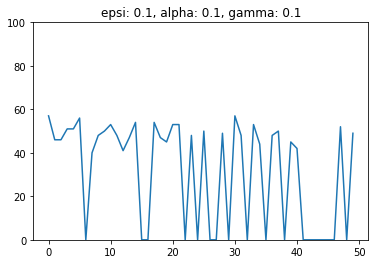

Training Phase, epoch 10000, elapsed time:58.70
Training Phase, epoch 20000, elapsed time:58.31
Training Phase, epoch 30000, elapsed time:58.15
Training Phase, epoch 40000, elapsed time:59.53


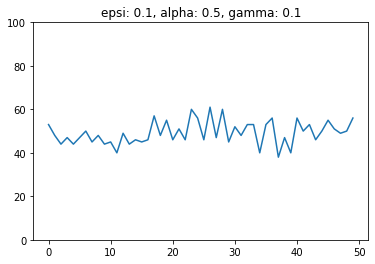

Training Phase, epoch 10000, elapsed time:58.84
Training Phase, epoch 20000, elapsed time:57.39
Training Phase, epoch 30000, elapsed time:57.97
Training Phase, epoch 40000, elapsed time:58.10


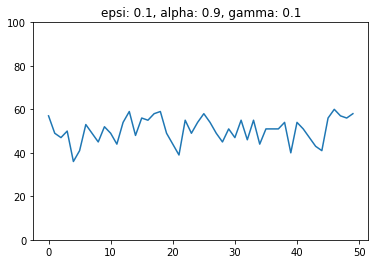

Training Phase, epoch 10000, elapsed time:62.47
Training Phase, epoch 20000, elapsed time:65.55
Training Phase, epoch 30000, elapsed time:64.02
Training Phase, epoch 40000, elapsed time:62.01


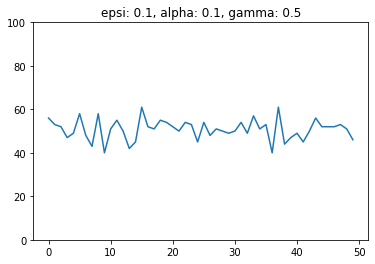

Training Phase, epoch 10000, elapsed time:60.67
Training Phase, epoch 20000, elapsed time:59.20
Training Phase, epoch 30000, elapsed time:58.69
Training Phase, epoch 40000, elapsed time:57.68


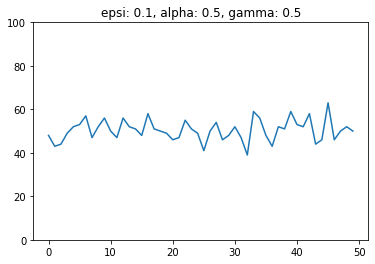

Training Phase, epoch 10000, elapsed time:49.98
Training Phase, epoch 20000, elapsed time:50.03
Training Phase, epoch 30000, elapsed time:41.03
Training Phase, epoch 40000, elapsed time:47.63


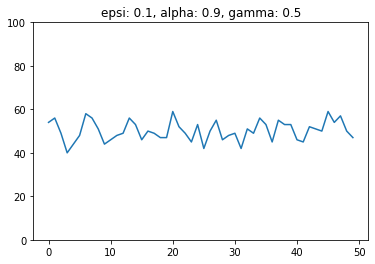

Training Phase, epoch 10000, elapsed time:50.63
Training Phase, epoch 20000, elapsed time:49.70
Training Phase, epoch 30000, elapsed time:49.84
Training Phase, epoch 40000, elapsed time:49.47


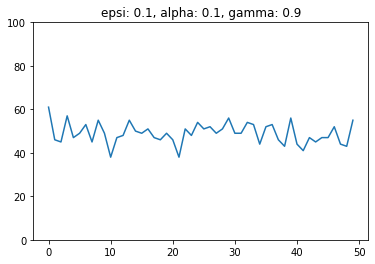

Training Phase, epoch 10000, elapsed time:51.98
Training Phase, epoch 20000, elapsed time:49.46
Training Phase, epoch 30000, elapsed time:50.46
Training Phase, epoch 40000, elapsed time:50.31


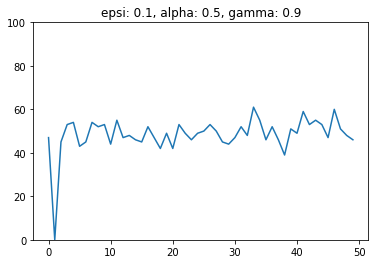

Training Phase, epoch 10000, elapsed time:49.56
Training Phase, epoch 20000, elapsed time:49.69
Training Phase, epoch 30000, elapsed time:51.62
Training Phase, epoch 40000, elapsed time:49.36


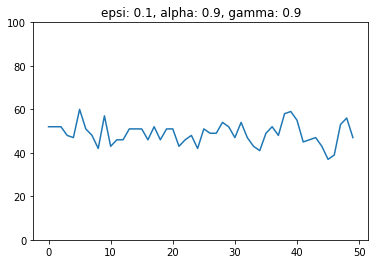

Training Phase, epoch 10000, elapsed time:50.77
Training Phase, epoch 20000, elapsed time:50.68
Training Phase, epoch 30000, elapsed time:51.06
Training Phase, epoch 40000, elapsed time:53.95


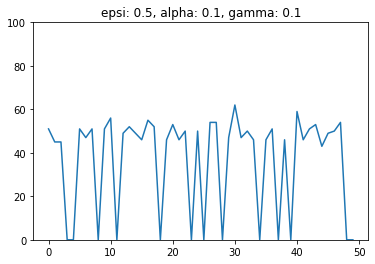

Training Phase, epoch 10000, elapsed time:54.35
Training Phase, epoch 20000, elapsed time:52.55
Training Phase, epoch 30000, elapsed time:54.51
Training Phase, epoch 40000, elapsed time:52.33


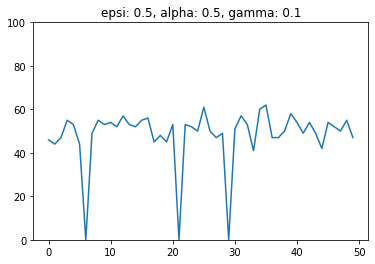

Training Phase, epoch 10000, elapsed time:47.28
Training Phase, epoch 20000, elapsed time:48.47
Training Phase, epoch 30000, elapsed time:55.40
Training Phase, epoch 40000, elapsed time:51.32


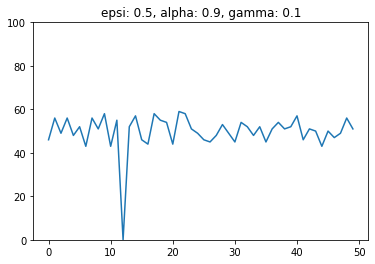

Training Phase, epoch 10000, elapsed time:50.63
Training Phase, epoch 20000, elapsed time:51.84
Training Phase, epoch 30000, elapsed time:50.64
Training Phase, epoch 40000, elapsed time:51.09


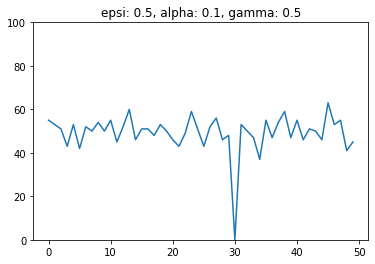

Training Phase, epoch 10000, elapsed time:52.57
Training Phase, epoch 20000, elapsed time:59.78
Training Phase, epoch 30000, elapsed time:60.16
Training Phase, epoch 40000, elapsed time:60.50


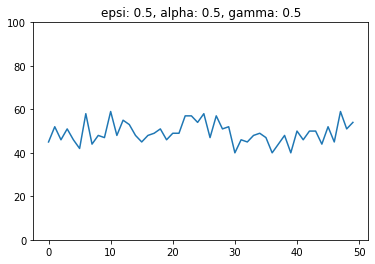

Training Phase, epoch 10000, elapsed time:57.52
Training Phase, epoch 20000, elapsed time:58.86
Training Phase, epoch 30000, elapsed time:59.08
Training Phase, epoch 40000, elapsed time:60.06


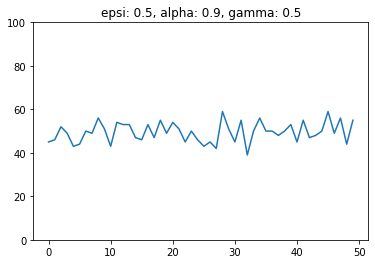

Training Phase, epoch 10000, elapsed time:48.45
Training Phase, epoch 20000, elapsed time:51.76
Training Phase, epoch 30000, elapsed time:50.22
Training Phase, epoch 40000, elapsed time:54.74


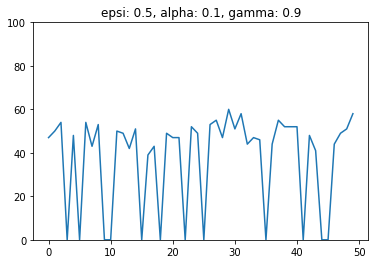

Training Phase, epoch 10000, elapsed time:57.23
Training Phase, epoch 20000, elapsed time:60.64
Training Phase, epoch 30000, elapsed time:58.56
Training Phase, epoch 40000, elapsed time:58.58


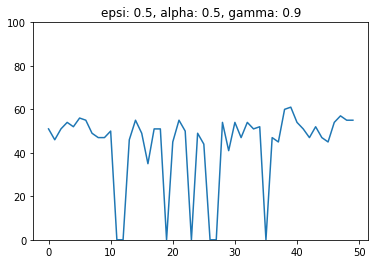

Training Phase, epoch 10000, elapsed time:57.89
Training Phase, epoch 20000, elapsed time:58.87
Training Phase, epoch 30000, elapsed time:60.53
Training Phase, epoch 40000, elapsed time:60.66


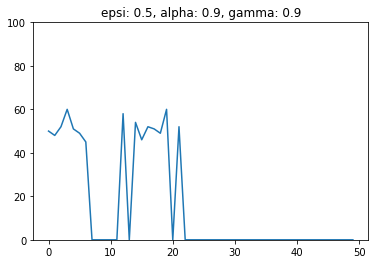

Training Phase, epoch 10000, elapsed time:50.58
Training Phase, epoch 20000, elapsed time:65.83
Training Phase, epoch 30000, elapsed time:63.88
Training Phase, epoch 40000, elapsed time:62.56


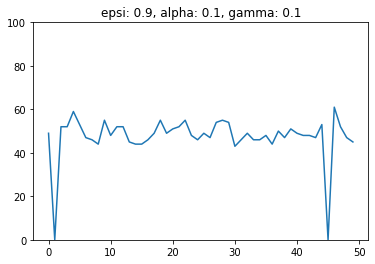

Training Phase, epoch 10000, elapsed time:50.72
Training Phase, epoch 20000, elapsed time:63.09
Training Phase, epoch 30000, elapsed time:63.26
Training Phase, epoch 40000, elapsed time:62.37


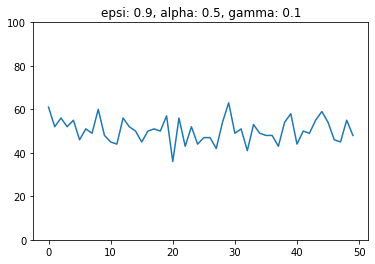

Training Phase, epoch 10000, elapsed time:51.66
Training Phase, epoch 20000, elapsed time:63.77
Training Phase, epoch 30000, elapsed time:63.57
Training Phase, epoch 40000, elapsed time:63.78


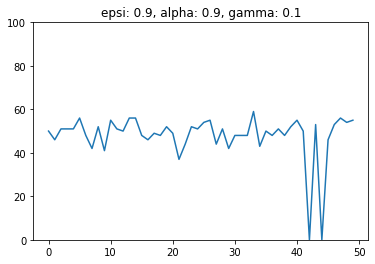

Training Phase, epoch 10000, elapsed time:325.26
Training Phase, epoch 20000, elapsed time:404.12
Training Phase, epoch 30000, elapsed time:1459.66
Training Phase, epoch 40000, elapsed time:52.71


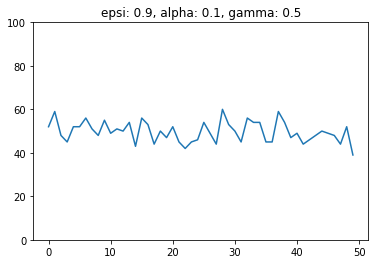

Training Phase, epoch 10000, elapsed time:41.67
Training Phase, epoch 20000, elapsed time:52.91
Training Phase, epoch 30000, elapsed time:57.49
Training Phase, epoch 40000, elapsed time:56.50


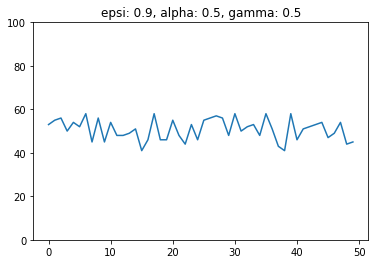

Training Phase, epoch 10000, elapsed time:40.70
Training Phase, epoch 20000, elapsed time:52.06
Training Phase, epoch 30000, elapsed time:52.76
Training Phase, epoch 40000, elapsed time:52.36


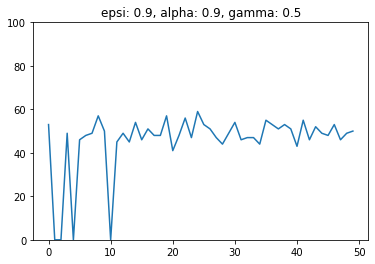

Training Phase, epoch 10000, elapsed time:42.47
Training Phase, epoch 20000, elapsed time:52.67
Training Phase, epoch 30000, elapsed time:52.62
Training Phase, epoch 40000, elapsed time:53.09


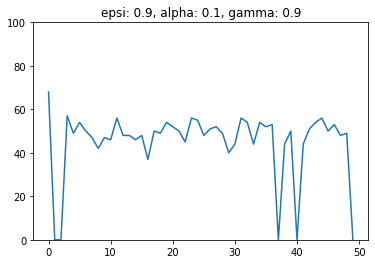

Training Phase, epoch 10000, elapsed time:41.62
Training Phase, epoch 20000, elapsed time:51.92
Training Phase, epoch 30000, elapsed time:52.89
Training Phase, epoch 40000, elapsed time:53.40


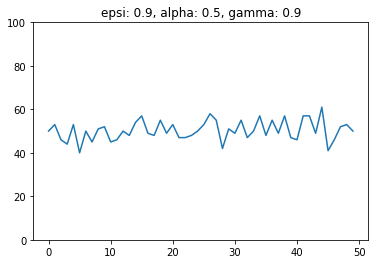

Training Phase, epoch 10000, elapsed time:43.26
Training Phase, epoch 20000, elapsed time:55.16
Training Phase, epoch 30000, elapsed time:55.63
Training Phase, epoch 40000, elapsed time:55.68


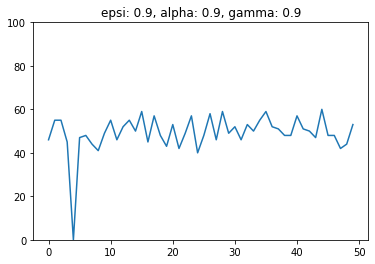

In [79]:
for e in np.linspace(0.1,0.9,3):
    for g in np.linspace(0.1,0.9,3):
        for a in np.linspace(0.1,0.9,3):
            test1 = tit_tac_toe(epsilon=e, alpha=a, gamma=g)
            test2 = tit_tac_toe()
            test2.load_Q('Q-150000.csv')
            test1.train(50000,evaluation = True,opponent = test2)
            plt.plot(test1.win_count_list)
            plt.ylim([0,100])
            plt.title(f'epsi: {e}, alpha: {a}, gamma: {g}')
            plt.show()
            